## learning-AI : deep learning application (61357002)
### assignment : diabetes classification (DL)

**당뇨 데이터를 1D-CNN 하여 classification (split_sequence 사용)**

<br>

- **임규연 (lky473736)**
- 2024.09.18.에 문서 작성
- **dataset** : https://github.com/plotly/datasets/blob/master/diabetes.csv
- **kaggle** : https://www.kaggle.com/datasets/mathchi/diabetes-data-set/data
- **data abstract** : This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective is to predict based on diagnostic measurements whether a patient has diabetes.

------

## <span id='dl'><mark>DL</mark></span>
    
deep learning으로 diabetes를 classification한다. **1D-CNN을 통하여 classification한다.** split_sequence()를 하여 CNN을 진행할 때 주의할 점은 아래와 같다.

- `(주의할 점 1) 적절한 timestep`
    - **앞으로는 EDA를 하기 전, uci dataset에 대한 설명을 먼저 정독한 후에 진행하자.**
    - 만약 특정 시계열 데이터셋이 있다고 가정할 때, 그에 대한 샘플링 속도는 50Hz라고 한다면, 이는 1초 동안 50개의 데이터를 수집했다는 의미이다. -> **따라서 1초 간의 활동을 포착하려고 할 때 타임스텝은 50으로 설정해야 하는 것이 일반적이다.**
    
- `(주의할 점 2) label counting의 불균형을 확인할 것`
    - **부족한 label에 해당되는 records의 수를 늘린다. (oversampling)**
    - 반대로, 너무 많은 label에 해당되는 records의 수는 감소한다. (undersampling)
    
- `(주의할 점 3) 많은 양의 records`
    - 파일에 들어있는 records 수가 많으면 시간 측면에서도 오래 걸리며, 원할한 학습이 이루어지지 않을 수 있다.
    - 따라서 데이터셋 중에서도, label이 고르고 각 feature가 정규분포 모양을 잘 따르고 있는 데이터셋을 선정하여 학습하는 것이 중요하다.



------


In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

In [71]:
df = pd.read_csv('../../data/diabetes.csv')

df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [72]:
# 결측치 확인 및 결측치를 각 열의 평균값으로 대체

for feature in df.columns :
    print (f'{feature}열의 결측치 존재 여부 : ', df[feature].isnull())
    print ('\n--------------\n')

print ("데이터의 총 결측치 수 : ", df.isnull().sum())

Pregnancies열의 결측치 존재 여부 :  0      False
1      False
2      False
3      False
4      False
       ...  
763    False
764    False
765    False
766    False
767    False
Name: Pregnancies, Length: 768, dtype: bool

--------------

Glucose열의 결측치 존재 여부 :  0      False
1      False
2      False
3      False
4      False
       ...  
763    False
764    False
765    False
766    False
767    False
Name: Glucose, Length: 768, dtype: bool

--------------

BloodPressure열의 결측치 존재 여부 :  0      False
1      False
2      False
3      False
4      False
       ...  
763    False
764    False
765    False
766    False
767    False
Name: BloodPressure, Length: 768, dtype: bool

--------------

SkinThickness열의 결측치 존재 여부 :  0      False
1      False
2      False
3      False
4      False
       ...  
763    False
764    False
765    False
766    False
767    False
Name: SkinThickness, Length: 768, dtype: bool

--------------

Insulin열의 결측치 존재 여부 :  0      False
1      False
2      False
3      False
4

In [73]:
# df의 기본적인 통계량 수치 파악, 각 열마다의 데이터 타입 

for feature in df.columns :
    print (f'{feature}의 데이터 타입 : ', df[feature].dtype)

df.describe()

Pregnancies의 데이터 타입 :  int64
Glucose의 데이터 타입 :  int64
BloodPressure의 데이터 타입 :  int64
SkinThickness의 데이터 타입 :  int64
Insulin의 데이터 타입 :  int64
BMI의 데이터 타입 :  float64
DiabetesPedigreeFunction의 데이터 타입 :  float64
Age의 데이터 타입 :  int64
Outcome의 데이터 타입 :  int64


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


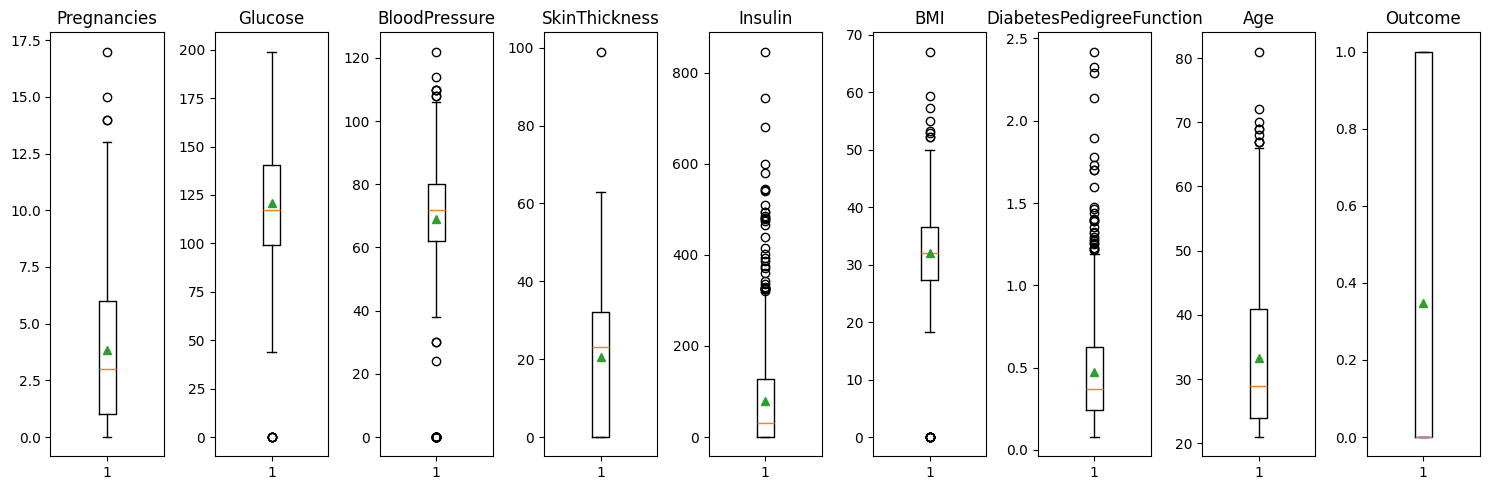

In [74]:
# box plot 그려 데이터 분포 확인

# subplot 생성
fig, axes = plt.subplots(nrows=1, ncols=df.shape[1], figsize=(15, 5))

# 각 변수에 대한 boxplot 그리기
for i, var in enumerate(df.columns) :
    ax = axes[i]
    ax.boxplot(df[var], showmeans=True)
    ax.set_title(var)

plt.tight_layout()
plt.show()

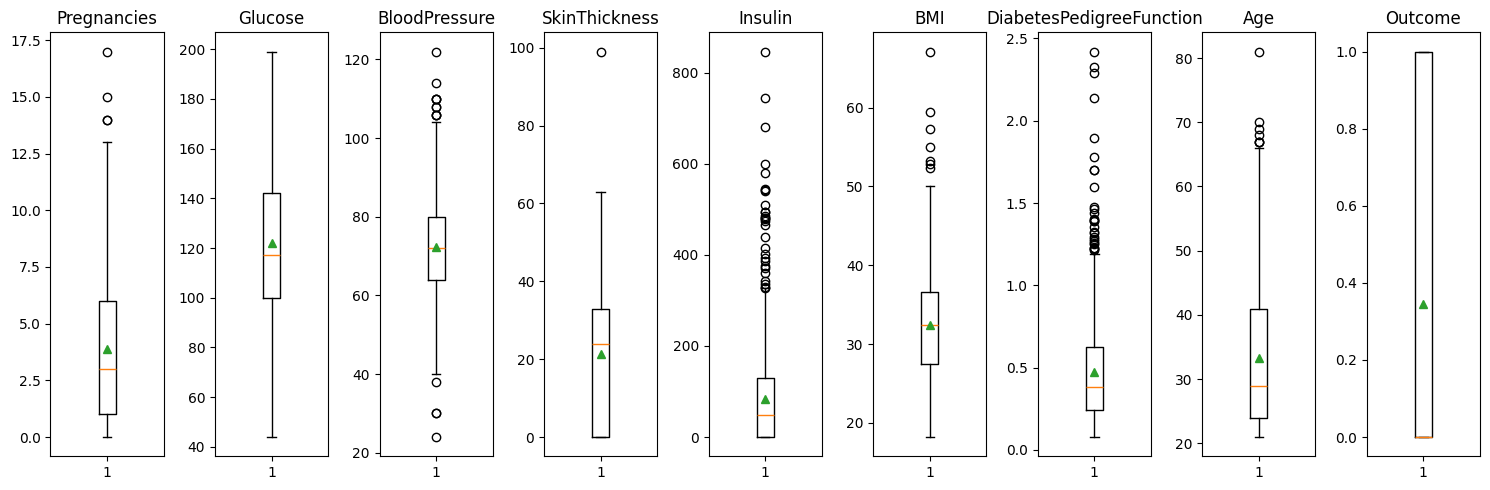

In [75]:
# outlier 제거 및 다시 boxplot 시각화

df = df[(df['BMI'] != 0) & (df['Glucose'] != 0) & (df['BloodPressure'] != 0)]

fig, axes = plt.subplots(nrows=1, ncols=df.shape[1], figsize=(15, 5))

for i, var in enumerate(df.columns) :
    ax = axes[i]
    ax.boxplot(df[var], showmeans=True)
    ax.set_title(var)

plt.tight_layout()
plt.show()

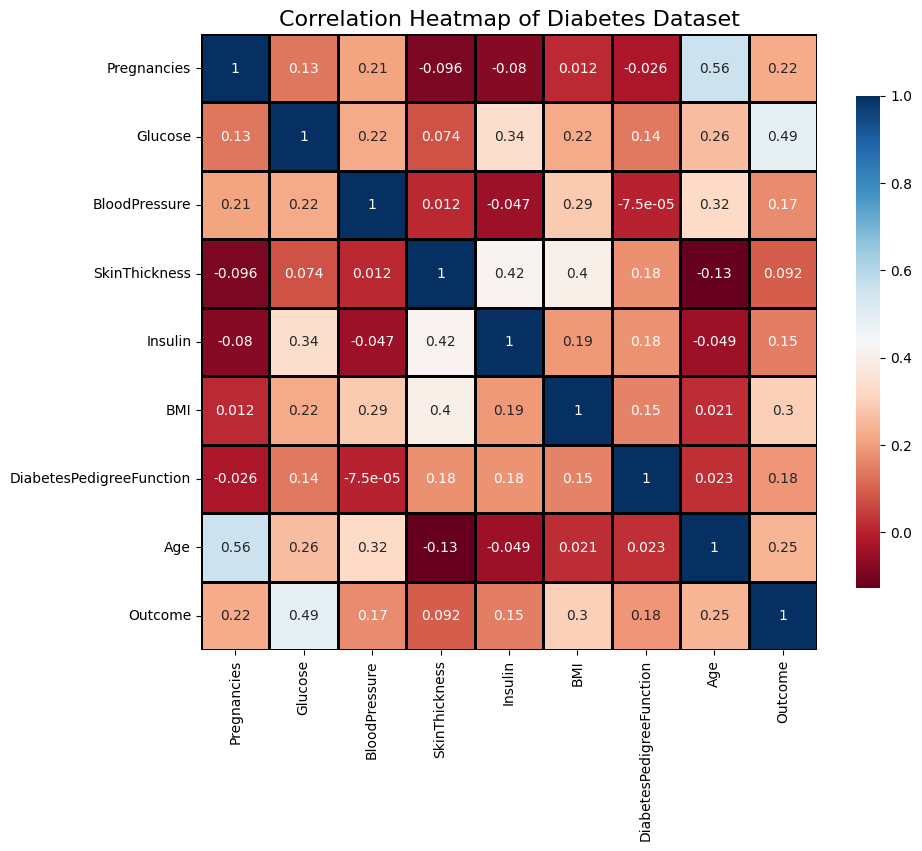

In [76]:
# heatmap

correlation_matrix = df[df.columns].corr() 
plt.figure(figsize=(10, 8)) 
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu', square=True,
            linewidths=1, linecolor='black', cbar_kws={"shrink": 0.8})

plt.title('Correlation Heatmap of Diabetes Dataset', fontsize=16)
plt.show()

본 데이터프레임에서의 각 attribute는 다음과 같은 내용을 의미한다.

- **임신 횟수 (Pregnancies)** : 임신한 횟수
- **포도당 (Glucose)** : 경구 포도당 내성 검사에서 2시간 후의 혈장 포도당 농도
- **혈압 (BloodPressure)** : 이완기 혈압 (mm Hg)
- **피부 두께 (SkinThickness)** : 삼두근 피부 두께 (mm)
- **인슐린 (Insulin)** : 2시간 후의 혈청 인슐린 (mu U/ml)
- **체질량 지수 (BMI)** : 체질량 지수 (몸무게(kg) / (키(m))^2)
- **당뇨병 혈통 함수 (DiabetesPedigreeFunction)** : 당뇨병 혈통 함수
- **나이 (Age)** : 나이 (년)
- **결과 (Outcome)** : 클래스 변수 (0 또는 1)

결국엔 맨 마지막 column인 Outcome 열이 target이 될 것이며, 나머지는 feature가 되어 classification을 진행해야 할 것이다. Outcome 열은 0 혹은 1로 이루어진 클래스 변수 (이진 변수)이며, 추후 편향 가능성 여부를 파악하기 위하여 countplot을 그려 확인해보자.

Outcome
0    475
1    249
Name: count, dtype: int64

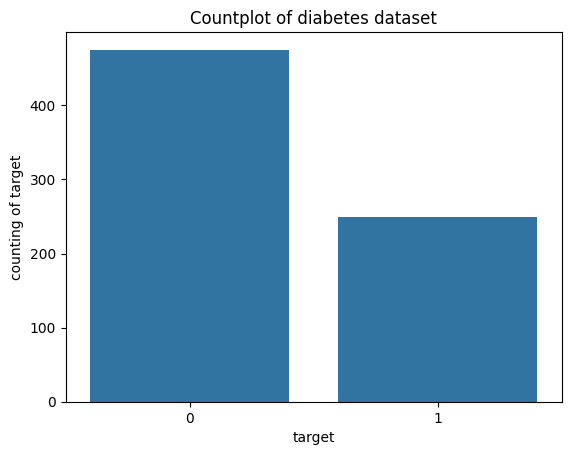

In [77]:
# target 별 counting

sns.countplot(data = df, x="Outcome")
plt.xlabel('target')
plt.ylabel("counting of target")
plt.title('Countplot of diabetes dataset')

df['Outcome'].value_counts()

위를 확인해보면, Outcome 열의 0과 1의 도수가 불균형하여 추후 분류 시 편향이 발생할 가능성이 높다. 따라서 아래와 같은 방안을 생각해볼 수 있다.

- 오버 샘플링 (oversampling)
    - 소수 클래스인 1의 데이터 갯수를 늘려 불균형을 해소한다.
    - 데이터 손실이 없는 것이 장점이지만, 학습 시간이 증가할 수 있다.
        - 현재 데이터 수가 그리 많지 않기 때문에 괜찮을 듯 하다.
- 언더 샘플링 (undersampling)
    - 다수 클래스인 0의 데이터 갯수를 줄여 불균형을 해소한다.
    - 오버 샘플링과 반대로 작용한다.

하지만 현재 classification의 주제는 당뇨병으로, target층을 일반인으로 데이터 수집 시 당연히 당뇨병 환자가 당뇨병에 걸리지 않은 사람보다 더 적다. 하지만 현재는 모델의 공평한 학습에 중점을 두어서 oversampling을 진행하도록 하겠다.

**공평한 학습을 위해선, train_test_split 함수에서 stratify 옵션을 사용하는 것이 핵심**이 되겠다. 이 옵션은 학습 데이터셋과 테스트 데이터셋 내에서 목표 변수의 분포를 동일하게 유지하는데, 만약 y 변수가 0과 1로 이루어진 이진 범주형 변수이고, 0의 비율이 25%, 1의 비율이 75%라면, stratify=y를 사용하면 랜덤 분할을 해도 0이 25%, 1이 75%인 비율을 유지할 수 있기 때문에 현재 target 분포에 꼭 필요한 옵션일 것이다.

In [78]:
'''
    oversampling과 undersampling을 함수로 구현한다. 
'''
    
def sampling(df, target_col, max_size) :
    # 결과를 저장할 리스트 
    dfs = []
    
    for label in df[target_col].unique() :
        class_df = df[df[target_col] == label]
        
        if len(class_df) < max_size :
            # 샘플 수가 max_size보다 적으면 데이터를 복제하여 max_size로 만듦
            sampled_df = class_df.sample(max_size, replace=True, random_state=42)
        else :
            # 샘플 수가 max_size보다 많으면 앞부분부터 max_size만큼 선택함
            sampled_df = class_df.head(max_size)
        
        # 리스트에 추가
        dfs.append(sampled_df)
    
    df_resampled = pd.concat(dfs).reset_index(drop=True)
    
    return df_resampled

df_resampled = sampling(df, 'Outcome', max_size=1000)
print (df_resampled['Outcome'].value_counts())

Outcome
1    1000
0    1000
Name: count, dtype: int64


<img src="./loss_fig_many_times.png" width="500px">

**위 figure은 validation loss가 epoch가 증가함에 따라 같이 증가하는 현상을 그래프화한 것이다. 총 17번에 hyperparameter tuning과 model structure redesign (복잡도 낮추기), regularization layer (가중치 패널티) 도입에도 불구하고 위와 비슷한 양상의 figure가 그려졌다.** 따라서, 나는 아래와 같은 결론에 도달했다.

- **(해결책 1) data augmentation을 통하여 노이즈를 일부러 주입시킨다**
    - **오직 일반화를 위하여 이러는 것**이다. 작은 변동성에 덜 민감하게 반응하기 위함이다.
    - **(1) Gaussian noise를 만드는 메소드를 직접 만들어서 df를 변형한다.**
        - 단, 위 셀을 통해 oversampling된 상태에서 진행한다. (아무리 noise를 주입한다고 해도 기존의 데이터는 충분해야 하기 때문에) 
        - parameter로 rate를 놓아 df의 몇퍼센트까지 noise로 변하게 할 지를 결정한다.
        - ```python
        def add_noise(data: pd.DataFrame, noise_level: float) -> pd.DataFrame :
            noisy_data = data.copy()
            feature_columns = noisy_data.columns.difference(['target'])  
            noise = np.random.normal(loc=0, scale=noise_level, size=noisy_data[feature_columns].shape)
            noisy_data[feature_columns] += noise
            return noisy_data
        ```
    - **(2) Mixup 방식을 사용한다.**
        - 원본 데이터의 두 샘플을 선형적으로 결합하여 새로운 샘플을 생성하는 것이다.
        - 모델이 다양한 상황을 학습하게 되며, 데이터의 변형을 통해 모델의 견고성을 높이게 하는 것이 목적이 되겠다.
        - ```python
        def mixup_data(data: pd.DataFrame, alpha: float) -> pd.DataFrame :
            feature_columns = data.columns.difference(['target'])  
            num_samples = len(data)

            lambdas = np.random.beta(alpha, alpha, size=num_samples)
            mixed_data = data.copy()

            for i in range(num_samples):
                # 랜덤하게 섞기
                j = np.random.choice(num_samples)

                # feature 섞기
                mixed_data.loc[i, feature_columns] = lambdas[i] * data.loc[i, feature_columns] + (1 - lambdas[i]) * data.loc[j, feature_columns]
                
                # target 섞기 
                mixed_data.loc[i, 'target'] = lambdas[i] * data.loc[i, 'target'] + (1 - lambdas[i]) * data.loc[j, 'target']

            return mixed_data```
        
        - 하지만, 보통 **Mixup은 target이 연속형 데이터에서 사용하므로, lambda 함수로 반올림을 하여 0과 1을 구성**하도록 만든다.
       
    
- **(해결책 2) 위 방법으로 안되면, model complexity를 아주 줄여서 최대한 loss가 커지지 않는 방향으로 한다.**
    - 노드 수 감소
    - optimizer 변경해보기
        - Adam -> RMSprop
      

In [79]:
def add_noise(data: pd.DataFrame, noise_level: float) -> pd.DataFrame :
                      noisy_data = data.copy()
                      feature_columns = noisy_data.columns.difference(['Outcome'])  
                      noise = np.random.normal(loc=0, scale=noise_level, size=noisy_data[feature_columns].shape)
                      noisy_data[feature_columns] += noise
                      return noisy_data

In [80]:
# def mixup_data(data: pd.DataFrame, alpha: float) -> pd.DataFrame :
#                                                           feature_columns = data.columns.difference(['Outcome'])  
#                                                           num_samples = len(data)

#                                                           lambdas = np.random.beta(alpha, alpha, size=num_samples)
#                                                           mixed_data = data.copy()

#                                                           for i in range(num_samples):
#                                                               # 랜덤하게 섞기
#                                                               j = np.random.choice(num_samples)

#                                                               # feature 섞기
#                                                               mixed_data.loc[i, feature_columns] = lambdas[i] * data.loc[i, feature_columns] + (1 - lambdas[i]) * data.loc[j, feature_columns]

#                                                               # target 섞기 
#                                                               mixed_data.loc[i, 'Outcome'] = lambdas[i] * data.loc[i, 'Outcome'] + (1 - lambdas[i]) * data.loc[j, 'Outcome']

#                                                           return mixed_data


def mixup_data_binary(data: pd.DataFrame, alpha: float) -> pd.DataFrame : 
    feature_columns = data.columns.difference(['Outcome']) 
    num_samples = len(data)
    
    lambdas = np.random.beta(alpha, alpha, size=num_samples)
    mixed_data = data.copy()
    
    for i in range(num_samples) :
        # 랜덤하게 다른 샘플 선택
        j = np.random.choice(num_samples)
        
        # 특성 섞기
        mixed_data.loc[i, feature_columns] = lambdas[i] * data.loc[i, feature_columns] + (1 - lambdas[i]) * data.loc[j, feature_columns]
        
        # 타겟 섞기 및 0 또는 1로 "반올림"
        mixed_data.loc[i, 'Outcome'] = round(lambdas[i] * data.loc[i, 'Outcome'] + (1 - lambdas[i]) * data.loc[j, 'Outcome'])
    
    return mixed_data


In [81]:
# 노이즈 추가
noisy_data = add_noise(df_resampled, noise_level=0.2)

# Mixup 적용
augmented_data = mixup_data_binary(noisy_data, alpha=0.2)

# df_augmented
df_augmented = augmented_data

print ("after augmentation : ", df_augmented.shape)
df_augmented.head()


after augmentation :  (2000, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,-0.241572,106.127319,63.848326,29.746567,71.401805,36.598907,0.760926,24.830119,1
1,9.105286,72.028436,77.975876,24.944610,0.213516,31.378064,0.471955,37.895530,0
2,11.119280,108.999895,62.298802,5.632660,209.313019,26.968451,1.154161,41.648680,1
3,9.942563,125.349464,69.843378,26.193904,115.112026,31.517768,0.175177,40.398564,1
4,2.292945,127.626318,78.069795,37.064049,181.746631,43.264142,1.084697,31.022081,1


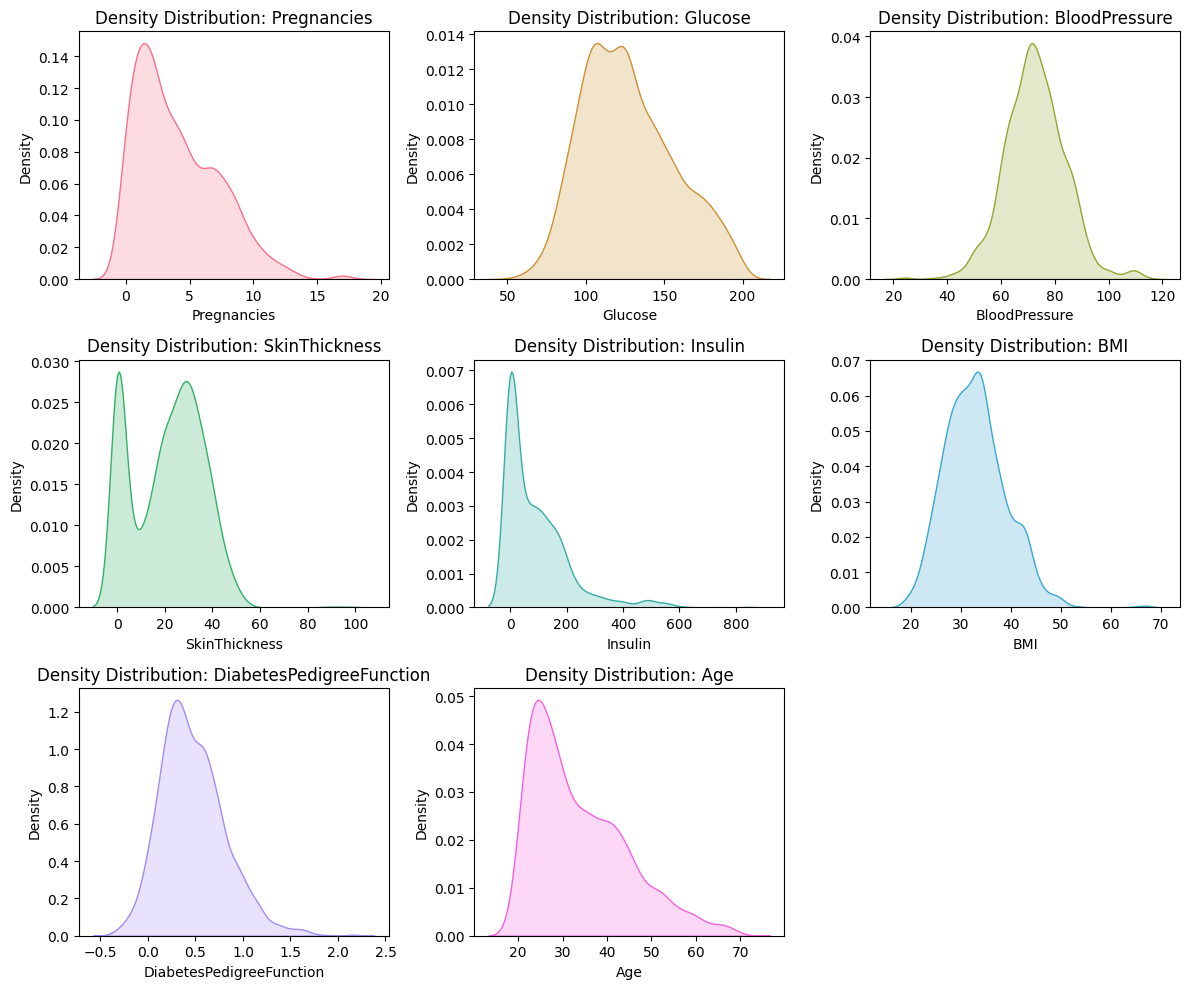

In [82]:
# 정규화 전, 각 feature마다 분포 확인하기

features = df_augmented.columns[:-1]  # 'Outcome' 제외

plt.figure(figsize=(12, 10))

for i, feature in enumerate (features) :
    plt.subplot(3, 3, i+1)
    sns.kdeplot(df_augmented[feature], fill=True, color=sns.color_palette("husl", len(features))[i])
    plt.title(f'Density Distribution: {feature}')
    plt.xlabel(feature)
    plt.ylabel('Density')

plt.tight_layout()
plt.show()

- 위 density distribution을 확인해보니, 대부분이 왼쪽으로 치우친 분포 모형을 띄고 있다. 
- 전체적인 normalization으로 모든 수치의 범위를 0~1로 조정한다.

In [83]:
# split the input, target

diabetes_input = df_augmented.drop(columns=['Outcome'])
diabetes_target = df_augmented['Outcome']

print (diabetes_input.head())
print ('\n')
print (diabetes_target.head())

   Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
0    -0.241572  106.127319      63.848326      29.746567   71.401805   
1     9.105286   72.028436      77.975876      24.944610    0.213516   
2    11.119280  108.999895      62.298802       5.632660  209.313019   
3     9.942563  125.349464      69.843378      26.193904  115.112026   
4     2.292945  127.626318      78.069795      37.064049  181.746631   

         BMI  DiabetesPedigreeFunction        Age  
0  36.598907                  0.760926  24.830119  
1  31.378064                  0.471955  37.895530  
2  26.968451                  1.154161  41.648680  
3  31.517768                  0.175177  40.398564  
4  43.264142                  1.084697  31.022081  


0    1
1    0
2    1
3    1
4    1
Name: Outcome, dtype: int64


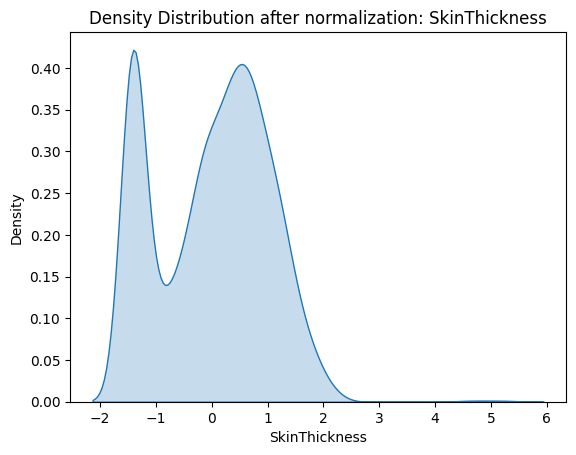

In [84]:
# Z-score normalization

from sklearn.preprocessing import StandardScaler

normalizer = StandardScaler()
diabetes_input_scaled = pd.DataFrame(normalizer.fit_transform(diabetes_input), 
                              columns=features)  

# 예시로, SkinThickness를 시각화하여 normalization이 잘 되었는지 확인해보기
sns.kdeplot(diabetes_input_scaled['SkinThickness'], fill=True)
plt.title(f'Density Distribution after normalization: SkinThickness')
plt.xlabel('SkinThickness')
plt.ylabel('Density')
plt.show()

In [85]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(diabetes_input_scaled,
                                                    diabetes_target,
                                                    stratify=diabetes_target,
                                                    test_size = 0.3) 

X_train.shape, y_train.shape 

((1400, 8), (1400,))

In [86]:
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
    # find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

'''
    이 함수로 순환형 데이터를 구성할 것
'''

'\n    이 함수로 순환형 데이터를 구성할 것\n'

**split_sequence에 대한 자세한 관찰은 https://github.com/lky473736/learning-AI/blob/main/insight/insight_3_split_sequence_and_CNN.ipynb 을 참고.**

- (1) 이 함수는 특정 스텝에 따라 X의 component를 각각 생성 후, 그에 따른 y값은 X component의 마지막 인덱스 + 1의 값을 지정하여 dataset을 만드는 과정을 담고 있다는 것을 확인 가능하다. 잘 생각해보면, X와 y가 서로 붙어서 전진하면서 dataset을 이룬다. 
- (2) index out of range 문제를 해결하기 위하여, 만약 최종 인덱스보다 마지막 인덱스가 크다면, 즉 y가 존재할 인덱스가 마지막 인덱스보다 크다면 범위를 벗어나는 것이기에 반복문을 종료하는 것을 알 수 있다.
- (3) time-series data이기 때문에 각 데이터들의 선후관계 및 순서가 중요한 상황에서 사용된다.

In [87]:
train_set = np.c_[X_train, y_train]
test_set = np.c_[X_test, y_test]

print ("before : ", train_set.shape, test_set.shape)

X_train_seq, y_train_seq = split_sequences(train_set, 4) # 4개씩 묶기
print (X_train_seq)
print (y_train_seq)

print ("train : ", X_train_seq.shape, y_train_seq.shape)

X_test_seq, y_test_seq = split_sequences(test_set, 4)
print (X_test_seq)
print (y_test_seq)

print ("test : ", X_test_seq.shape, y_test_seq.shape)

before :  (1400, 9) (600, 9)
[[[-9.16191553e-01  5.64081245e-01  7.93714855e-01 ...  1.38451486e+00
    2.92825909e-01 -5.37251735e-01]
  [-1.17513652e+00  3.39101598e-01 -2.61403251e-01 ...  1.81357689e-03
   -1.59592363e+00 -1.10895381e+00]
  [ 3.23829733e-02  5.21661482e-01  1.17314605e+00 ...  1.80424417e+00
    7.18296541e-01 -1.14313075e+00]
  [ 9.11944345e-01 -8.30375562e-01 -5.70519656e-01 ...  9.63292220e-01
   -5.16616445e-01 -2.70718888e-01]]

 [[-1.17513652e+00  3.39101598e-01 -2.61403251e-01 ...  1.81357689e-03
   -1.59592363e+00 -1.10895381e+00]
  [ 3.23829733e-02  5.21661482e-01  1.17314605e+00 ...  1.80424417e+00
    7.18296541e-01 -1.14313075e+00]
  [ 9.11944345e-01 -8.30375562e-01 -5.70519656e-01 ...  9.63292220e-01
   -5.16616445e-01 -2.70718888e-01]
  [-7.76759761e-01 -8.25185019e-01 -1.88145621e+00 ... -7.83907932e-01
    2.80791319e+00 -8.19319464e-01]]

 [[ 3.23829733e-02  5.21661482e-01  1.17314605e+00 ...  1.80424417e+00
    7.18296541e-01 -1.14313075e+00]
  [ 

In [88]:
# one-hot encoding 

from tensorflow.keras.utils import to_categorical

y_train_seq_encoded = to_categorical(y_train_seq)
y_test_seq_encoded = to_categorical(y_test_seq)

print(y_train_seq[:5])  
print(y_train_seq_encoded[:5]) 

print(y_test_seq[:5])  
print(y_test_seq_encoded[:5]) 

[1. 0. 1. 0. 0.]
[[0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]]
[0. 1. 1. 1. 0.]
[[1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]]


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 4, 8)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 4, 16)          │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 4, 16)          │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 2, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 2, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 2, 16)          │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 2, 16)          │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 1, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 16)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,354 (5.29 KB)

 Trainable params: 1,290 (5.04 KB)

 Non-trainable params: 64 (256.00 B)

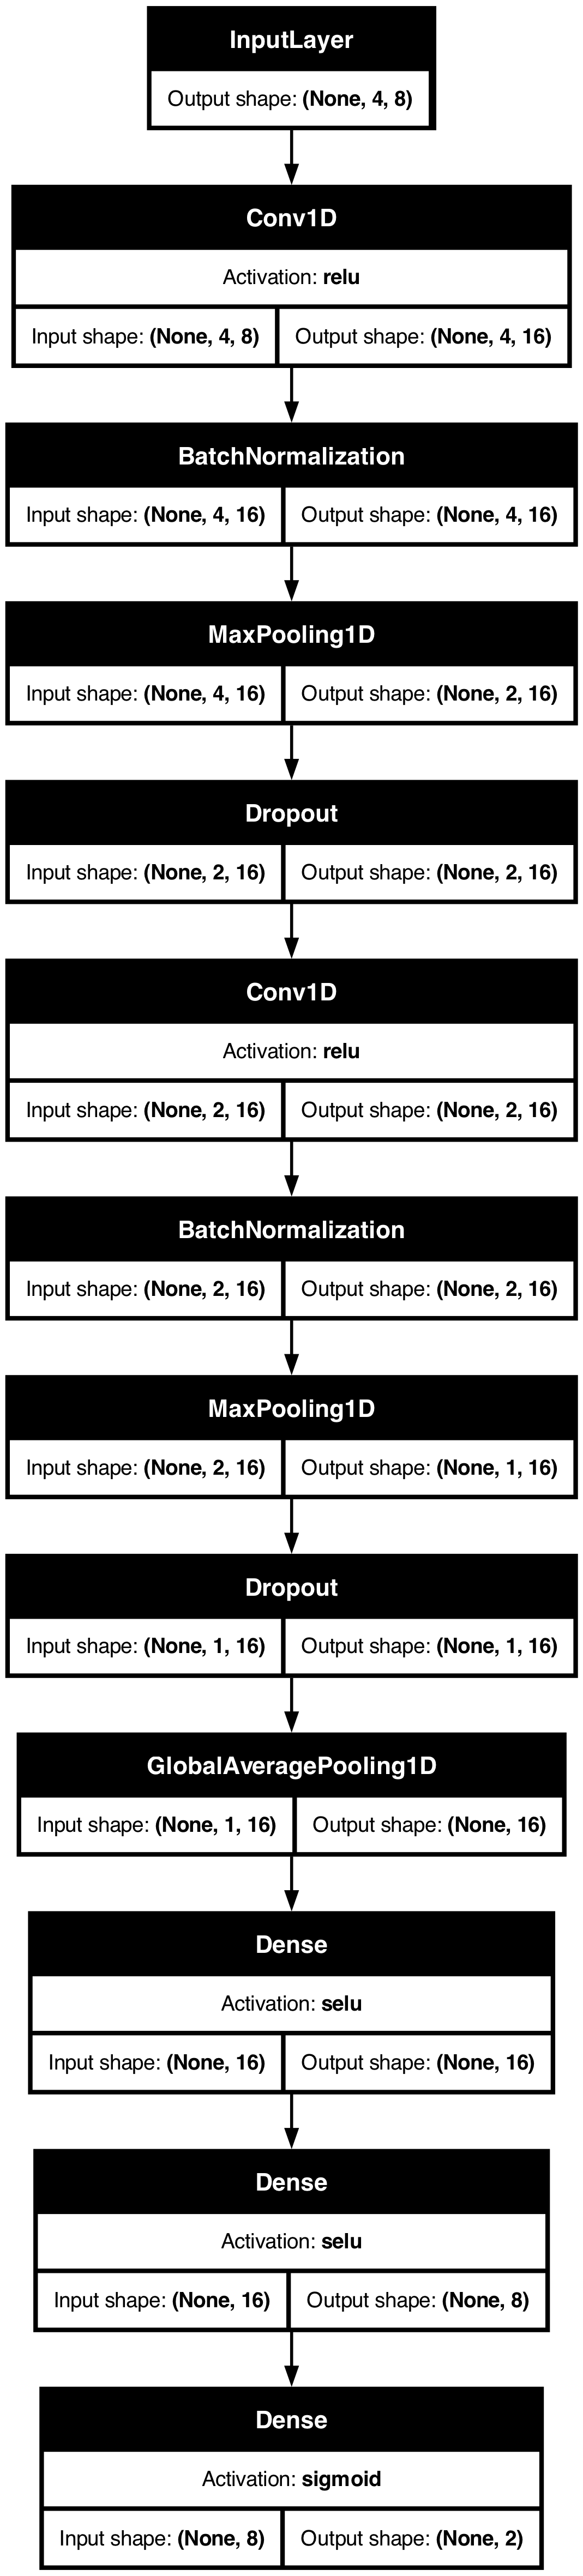

In [89]:
# modeling

from tensorflow.keras import regularizers

input_layer = keras.Input(shape=(X_train_seq.shape[1], X_train_seq.shape[2]))

# 첫 번째 Conv1D 레이어 + BatchNormalization + MaxPooling1D + Dropout
conv_1 = keras.layers.Conv1D(16, kernel_size=2, activation='relu', padding='same', 
                             kernel_regularizer=regularizers.l2(0.001))(input_layer)
batch_1 = keras.layers.BatchNormalization()(conv_1)
pooling_1 = keras.layers.MaxPooling1D(2, padding='same')(batch_1)
dropout_1 = keras.layers.Dropout(0.2)(pooling_1)

# 두 번째 Conv1D 레이어 + BatchNormalization + MaxPooling1D + Dropout
conv_2 = keras.layers.Conv1D(16, kernel_size=2, activation='relu', padding='same', 
                             kernel_regularizer=regularizers.l2(0.001))(dropout_1)
batch_2 = keras.layers.BatchNormalization()(conv_2)
pooling_2 = keras.layers.MaxPooling1D(2, padding='same')(batch_2)
dropout_2 = keras.layers.Dropout(0.2)(pooling_2)

# flatten 대신에 pooling1D를 사용해봄
global_pool = keras.layers.GlobalAveragePooling1D()(dropout_2)

'''
    계속적으로 val_loss가 늘어나는 현상 발견
    regularizer를 추가하여 l2 규제를 하게끔 함
    l1 규제 : 절댓값 규제 (특정 feature을 0으로 만들 수 있음)
    l2 규제 : 제곱 규제 (특정 feature을 0과 가깝게 만들 수 있음)
'''

# Dense 레이어
dense_1 = keras.layers.Dense(16, activation='selu', 
                             kernel_regularizer=regularizers.l2(0.001))(global_pool)
dense_2 = keras.layers.Dense(8, activation='selu', 
                             kernel_regularizer=regularizers.l2(0.001))(dense_1)

output_layer = keras.layers.Dense(len(set(y_train.tolist())), activation='sigmoid')(dense_2)

model = keras.Model(inputs=input_layer, outputs=output_layer)

model.summary()
keras.utils.plot_model(model, show_shapes=True, show_layer_activations=True)

In [90]:
# compile

optimizer = keras.optimizers.Adam(learning_rate=0.0005)
model.compile (optimizer=optimizer, 
               loss='categorical_crossentropy', 
               metrics=['accuracy'])

In [91]:
# fit

# early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, 
#                                                 restore_best_weights=True)

from memory_profiler import profile

@profile # 메모리 오버플로우로 인한 시스템 다운을 막기 위해서
def train_model() :
    history = model.fit(X_train_seq, y_train_seq_encoded, epochs=120, 
                        validation_split=0.1, 
#                         callbacks=early_stopping_cb, 
                        verbose=True)
    
    return history
    
history = train_model()
print (history)

ERROR: Could not find file /var/folders/_z/gryfr07n59jgb3wrd062h1ym0000gn/T/ipykernel_10570/2547718829.py
Epoch 1/120
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.5243 - loss: 0.9320 - val_accuracy: 0.5429 - val_loss: 0.7562
Epoch 2/120
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5785 - loss: 0.7689 - val_accuracy: 0.5786 - val_loss: 0.7346
Epoch 3/120
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5680 - loss: 0.7779 - val_accuracy: 0.6071 - val_loss: 0.7128
Epoch 4/120
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6080 - loss: 0.7296 - val_accuracy: 0.5857 - val_loss: 0.7060
Epoch 5/120
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6245 - loss: 0.7130 - val_accuracy: 0.6357 - val_loss: 0.6975
Epoch 6/120
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6301 - loss: 0.7015 - val_accuracy: 0.6429 - val_loss: 0.6928
Epoch 7/120
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6477 - loss: 0.6838 - val_accuracy: 0.6643 - val_loss: 0.6848
Epoc

Epoch 51/120
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7651 - loss: 0.5226 - val_accuracy: 0.7143 - val_loss: 0.6053
Epoch 52/120
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7731 - loss: 0.5326 - val_accuracy: 0.7071 - val_loss: 0.5985
Epoch 53/120
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7957 - loss: 0.5067 - val_accuracy: 0.7071 - val_loss: 0.5988
Epoch 54/120
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7714 - loss: 0.5277 - val_accuracy: 0.7000 - val_loss: 0.5973
Epoch 55/120
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8005 - loss: 0.4936 - val_accuracy: 0.7143 - val_loss: 0.6016
Epoch 56/120
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7868 - loss: 0.5197 - val_accuracy: 0.7143 - val_loss: 0.6041
Epoch 57/120
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7659 - loss: 0.5264 - val_accuracy: 0.7000 - val_loss: 0.6028
Epoch 58/120
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7700 - loss: 0.5328 - val_accuracy: 0.

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8056 - loss: 0.4774 - val_accuracy: 0.7071 - val_loss: 0.6058
Epoch 102/120
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8132 - loss: 0.4703 - val_accuracy: 0.7143 - val_loss: 0.6090
Epoch 103/120
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8085 - loss: 0.4642 - val_accuracy: 0.7143 - val_loss: 0.6102
Epoch 104/120
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8077 - loss: 0.4745 - val_accuracy: 0.7143 - val_loss: 0.6063
Epoch 105/120
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7825 - loss: 0.4657 - val_accuracy: 0.7357 - val_loss: 0.6046
Epoch 106/120
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8195 - loss: 0.4628 - val_accuracy: 0.7286 - val_loss: 0.6061
Epoch 107/120
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8112 - loss: 0.4753 - val_accuracy: 0.7143 - val_loss: 0.6018
Epoch 108/120
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7757 - loss: 0.5151 - val_accuracy: 0.7071 -

{'accuracy': [0.5258551836013794, 0.5871121883392334, 0.577565610408783, 0.6006364226341248, 0.6332537531852722, 0.6276849508285522, 0.6340492963790894, 0.6539379358291626, 0.6571201086044312, 0.6626889705657959, 0.6738265752792358, 0.6666666865348816, 0.6897374987602234, 0.6857597231864929, 0.7040572762489319, 0.7088305354118347, 0.7120127081871033, 0.7032617330551147, 0.7024661898612976, 0.7191726565361023, 0.7088305354118347, 0.7255370020866394, 0.7207637429237366, 0.7438345551490784, 0.7279236316680908, 0.7382656931877136, 0.7311058044433594, 0.7414478659629822, 0.7390612363815308, 0.7454256415367126, 0.7525855302810669, 0.7438345551490784, 0.7549721598625183, 0.7430389523506165, 0.7661097645759583, 0.7494033575057983, 0.7486078143119812, 0.7692919373512268, 0.7621320486068726, 0.740652322769165, 0.7621320486068726, 0.7486078143119812, 0.7637231349945068, 0.7867939472198486, 0.7509944438934326, 0.7581543326377869, 0.7756563425064087, 0.7661097645759583, 0.7692919373512268, 0.766109

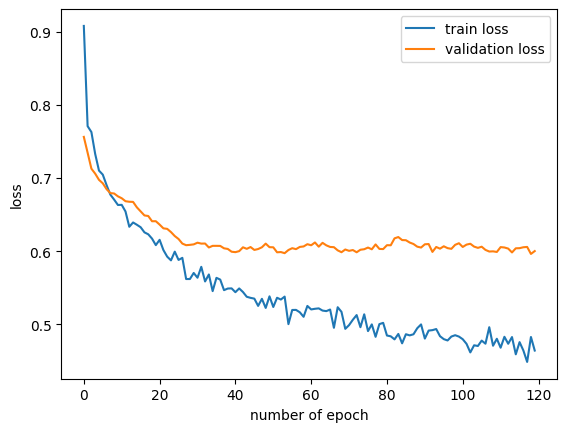

In [92]:
# history 그리고 loss 시각화

print (history.history)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('number of epoch')
plt.ylabel('loss')
plt.legend (['train loss', 'validation loss'])
plt.show() 

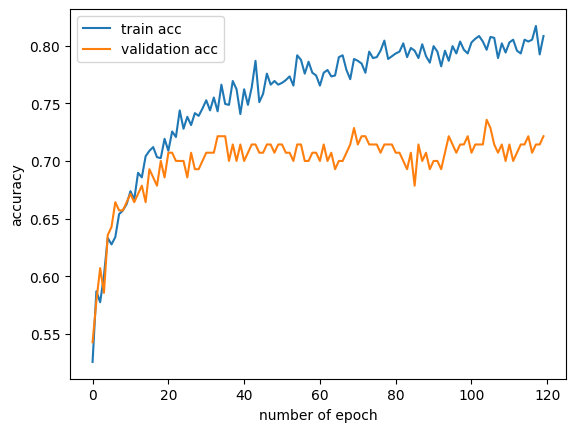

In [93]:
# acc 시각화

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('number of epoch')
plt.ylabel('accuracy')
plt.legend (['train acc', 'validation acc'])
plt.show() 

In [94]:
# classification report, confusion matrix

from sklearn.metrics import confusion_matrix, classification_report

y_test_pred = model.predict(X_test_seq)

print (y_test_pred)

y_test_pred_classes = np.argmax(y_test_pred, axis=1)

############

cm_test = confusion_matrix(y_test_seq, y_test_pred_classes)
print ("- test data confusion matrix -\n")
print (cm_test)

print ('\n --------------- \n')

cr_test = classification_report(y_test_seq, y_test_pred_classes)
print ("- test data report of classification -\n")
print (cr_test)

print ('\n --------------- \n')

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
[[0.9223033  0.23766205]
 [0.5803959  0.635189  ]
 [0.6773494  0.27082932]
 ...
 [0.31849504 0.32382327]
 [0.5170676  0.4562825 ]
 [0.35795927 0.4778451 ]]
- test data confusion matrix -

[[227  77]
 [ 80 213]]

 --------------- 

- test data report of classification -

              precision    recall  f1-score   support

         0.0       0.74      0.75      0.74       304
         1.0       0.73      0.73      0.73       293

    accuracy                           0.74       597
   macro avg       0.74      0.74      0.74       597
weighted avg       0.74      0.74      0.74       597


 --------------- 



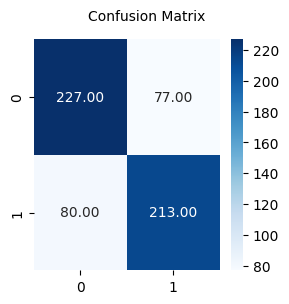

In [95]:
# seaborn으로 confusion matrix 시각화

fig, axes = plt.subplots(figsize=(3, 3))

# heatmap
sns.heatmap(cm_test, annot=True, cmap='Blues', fmt='.2f')

fig.suptitle('Confusion Matrix\n\n', fontsize=10)
plt.show()

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step


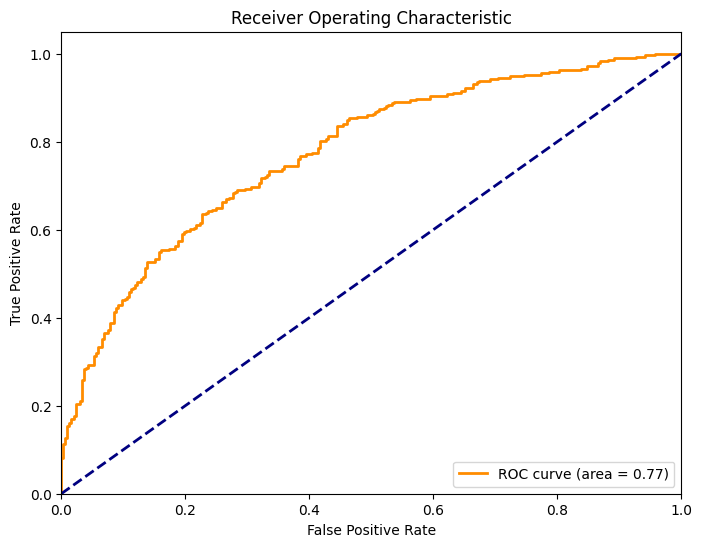

In [96]:
# ROC 시각화

from sklearn.metrics import roc_curve, roc_auc_score

y_test_pred_proba = model.predict(X_test_seq)
fpr, tpr, thresholds = roc_curve(y_test_seq, y_test_pred_proba[:, 1])
roc_auc = roc_auc_score(y_test_seq, y_test_pred_proba[:, 1])

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()
